In [24]:
import cv2
import opencv_jupyter_ui as jcv2
from feat import Detector
from IPython.display import Image


from feat.utils import FEAT_EMOTION_COLUMNS

In [25]:
detector = Detector(device="cuda")

INFO:root:Loading Face model: retinaface
g:\My Drive\Uppsala\IIS\venv\Lib\site-packages\feat\face_detectors\Retinaface\Retinaface_test.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

In [26]:
import os

# Construct the path to the image folder
ori_folder_path = os.path.join( '..', 'dataset', 'images')


# load all the images in the folder
images_filename = os.listdir(ori_folder_path)

# AU codes
predicted_aus = ["AU1","AU2","AU4","AU5","AU6","AU7","AU9","AU10","AU11","AU12","AU14","AU15",
                    "AU17","AU20","AU23","AU24","AU25","AU26","AU28", "AU43"]

In [27]:
import pandas as pd
df = pd.DataFrame(columns=['file', 'face']+predicted_aus)

In [28]:
# loop through all the images
for image_filename in images_filename:
    frame = cv2.imread(ori_folder_path + "/" + image_filename)
    faces = detector.detect_faces(frame)
    landmarks = detector.detect_landmarks(frame, faces)
    emotions = detector.detect_emotions(frame, faces, landmarks)
    AUs = detector.detect_aus(frame, landmarks)
    faces = faces[0]
    landmarks = landmarks[0]
    emotions = emotions[0]
    AUs = AUs[0]

    strongest_emotion = emotions.argmax(axis=1)

    # draw rectangles around the faces
    for (face, top_emo) in zip(faces, strongest_emotion):
        (x0, y0, x1, y1, p) = face
        cv2.rectangle(frame, (int(x0), int(y0)), (int(x1), int(y1)), (255, 0, 0), 3)
        cv2.putText(frame, FEAT_EMOTION_COLUMNS[top_emo], (int(x0), int(y0 - 10)), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 0, 0), 2)
    
    # save each AUs to the dataframe
    for i in range(len(faces)):
        # remove .jpg from the image name
        filename = image_filename[:-4]
        row = [filename, i]
        row.extend(AUs[i])
        print(row)
        df.loc[len(df)] = row

    
    
    results_file_path = os.path.join('..', 'processed', 'images', image_filename)
    cv2.imwrite(results_file_path, frame)
# save the results to a csv file
results_file_path = os.path.join('..', 'processed', 'aus.csv')
df.to_csv(results_file_path, index=False)

INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 252, 252]) to 112
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 128, 128]) to 112
INFO:root:detecting emotions...
INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 150, 150]) to 112
INFO:root:detecting emotions...


['arguing', 0, 0.16011012, 0.102577746, 0.19994362, 0.36326078, 0.10479822, 0.0, 0.18710841, 0.002263664, 1.0, 0.0963532, 0.6176441, 0.31258872, 0.335158, 1.0, 0.59658545, 0.7543643, 0.097726606, 0.075133465, 0.10824404, 0.05937169]
['arguing', 1, 0.33938113, 0.13069762, 0.87304395, 0.459386, 0.06193259, 0.0, 0.20567137, 0.0031864722, 0.0, 0.011019649, 0.12876487, 0.44289538, 0.46687925, 0.0, 0.32606143, 0.479554, 0.004661042, 0.2086423, 0.8900709, 0.0476171]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 208, 208]) to 112
INFO:root:detecting emotions...


['back-off', 0, 0.45687678, 0.2965181, 0.28503653, 0.728858, 0.09013323, 0.0, 0.12228814, 0.0044453503, 1.0, 0.08960325, 0.17310187, 0.30619135, 0.2970357, 1.0, 0.2924097, 0.052131347, 0.9881373, 0.64094436, 0.027561827, 0.049748216]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 368, 368]) to 112
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 124, 124]) to 112
INFO:root:detecting emotions...


['bills', 0, 0.3858259, 0.15997788, 0.7090065, 0.24256177, 0.11328226, 0.0, 0.2601805, 0.012467018, 0.0, 0.049914487, 0.32804617, 0.60872906, 0.3453203, 0.0, 0.39372075, 0.6324975, 0.10310849, 0.13539085, 0.09640282, 0.8331898]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 236, 236]) to 112
INFO:root:detecting emotions...


['bullied', 0, 0.2969277, 0.08283452, 0.688827, 0.4785359, 0.15203543, 0.0, 0.11838149, 0.11172967, 0.0, 0.038521864, 0.45327303, 0.23413172, 0.6173191, 0.0, 0.6068636, 0.7969972, 0.040824566, 0.03392351, 0.2504066, 0.031960268]
['bullied', 1, 0.44179815, 0.4220888, 0.35493195, 0.49114597, 0.07050573, 0.0, 0.110902764, 0.0019600322, 0.0, 0.027124647, 0.24374871, 0.48307845, 0.4628548, 0.0, 0.61583275, 0.4718327, 0.028327039, 0.21456397, 0.17014109, 0.10045089]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 66, 66]) to 112
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 68, 68]) to 112
INFO:root:detecting emotions...


['business', 0, 0.24402763, 0.16114387, 0.37469837, 0.25481537, 0.7650437, 1.0, 0.42485765, 0.79858285, 0.0, 0.72541326, 0.7827393, 0.47254983, 0.26299253, 1.0, 0.23970328, 0.06719842, 0.99952006, 0.5560965, 0.034008496, 0.35411423]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 244, 244]) to 112
INFO:root:detecting emotions...


['by-the-sea', 0, 0.4029159, 0.20982614, 0.69109094, 0.25794134, 0.18049361, 0.0, 0.3971559, 0.00051072385, 0.0, 0.06588266, 0.7042297, 0.07524834, 0.37408638, 1.0, 0.53640175, 0.68855697, 0.38276404, 0.33340195, 0.34891826, 0.48535803]
['by-the-sea', 1, 0.6604061, 0.13245513, 0.66575533, 0.28880754, 0.10263333, 0.0, 0.49641135, 0.0014832994, 1.0, 0.06098844, 0.24189837, 0.70606816, 0.40178806, 0.0, 0.66651654, 0.44059986, 0.672276, 0.32024086, 0.1814811, 0.4275144]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 296, 296]) to 112
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 186, 186]) to 112
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 164, 164]) to 112
INFO:root:detecting emotions...


['claws', 0, 0.3000393, 0.087665886, 0.9399777, 0.34070703, 0.7387557, 1.0, 0.7690524, 0.97891265, 1.0, 0.892357, 0.40600738, 0.60891527, 0.22456059, 1.0, 0.38573682, 0.010386461, 0.9998512, 0.8972596, 0.031184876, 0.65596783]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 100, 100]) to 112
INFO:root:detecting emotions...


['disagreement', 0, 0.3338602, 0.28108263, 0.17375694, 0.57043904, 0.07360843, 0.0, 0.107921906, 0.0112428265, 1.0, 0.022202896, 0.21744567, 0.4875772, 0.48920792, 0.0, 0.45205027, 0.5597671, 0.0038420295, 0.067387946, 0.31039968, 0.027457464]
['disagreement', 1, 0.34343132, 0.19237801, 0.6458585, 0.21872523, 0.044165783, 0.0, 0.18495731, 0.0677798, 0.0, 0.018886503, 0.16894433, 0.4064159, 0.19545099, 0.0, 0.3131316, 0.21697196, 0.94353867, 0.83800477, 0.06503482, 0.13888632]
['disagreement', 2, 0.4624504, 0.27531672, 0.30560073, 0.33685797, 0.082020134, 0.0, 0.20246974, 0.381059, 1.0, 0.042369366, 0.44982943, 0.44391516, 0.44737142, 1.0, 0.60372216, 0.14240265, 0.9609394, 0.53639555, 0.12050401, 0.035720557]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 152, 152]) to 112
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 166, 166]) to 112
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 158, 158]) to 112
INFO:root:detecting emotions...


['enjoying-the-sun', 0, 0.43444607, 0.40842935, 0.23705173, 0.33665738, 0.7210349, 1.0, 0.38139966, 0.86821854, 1.0, 0.70778006, 0.5508149, 0.5479909, 0.5794551, 0.0, 0.3130288, 0.5982875, 0.878751, 0.42763606, 0.07815916, 0.8520111]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 110, 110]) to 112
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 130, 130]) to 112
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 138, 138]) to 112
INFO:root:detecting emotions...


['grandparents', 0, 0.2606018, 0.39730293, 0.3946398, 0.32555965, 0.6775281, 1.0, 0.64537185, 0.4700779, 0.0, 0.89686805, 0.67699975, 0.23312677, 0.25075072, 1.0, 0.28896648, 0.012868587, 0.99994826, 0.6126899, 0.10356483, 0.92353016]
['grandparents', 1, 0.50572866, 0.30954006, 0.4874248, 0.22420134, 0.9112764, 1.0, 0.80607367, 0.9227, 0.0, 0.93294245, 0.7245071, 0.26175734, 0.18511362, 1.0, 0.18943809, 0.010707204, 0.99998724, 0.8336627, 0.022059374, 0.26753086]
['grandparents', 2, 0.5602594, 0.16668464, 0.73208004, 0.34944212, 0.0873272, 0.0, 0.25531456, 0.07064337, 0.0, 0.02482552, 0.16347983, 0.320513, 0.5671428, 0.0, 0.7112647, 0.647744, 0.086872526, 0.43425235, 0.37611267, 0.57871205]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 206, 206]) to 112
INFO:root:detecting emotions...


['handshake', 0, 0.44864509, 0.3729738, 0.32093892, 0.2831761, 0.8378206, 1.0, 0.5934659, 0.9229402, 1.0, 0.96956784, 0.43720835, 0.18468055, 0.17917061, 1.0, 0.14038005, 0.018175209, 0.99995553, 0.31614408, 0.07539003, 0.13877052]
['handshake', 1, 0.2786147, 0.21115868, 0.33725622, 0.28027472, 0.7916151, 1.0, 0.62188125, 0.9868774, 0.0, 0.90172493, 0.70512724, 0.18813187, 0.3967027, 1.0, 0.39810148, 0.6206815, 0.9997874, 0.6128517, 0.6638826, 0.8941323]
['handshake', 2, 0.52511096, 0.53365767, 0.53516394, 0.27487174, 0.17935875, 0.0, 0.3009231, 0.16733834, 0.0, 0.07702514, 0.12072592, 0.67062175, 0.48721588, 1.0, 0.5019117, 0.38793665, 0.84067905, 0.63178533, 0.19105583, 0.8851942]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 304, 304]) to 112
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 161, 178]) to 112
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 320, 320]) to 112
INFO:root:detecting emotions...


['happy-man', 0, 0.41439435, 0.34339818, 0.22586314, 0.28678343, 0.9150376, 0.0, 0.50350803, 0.92107916, 1.0, 0.9784741, 0.5576907, 0.065610886, 0.34297514, 1.0, 0.15259285, 0.12801243, 0.9998405, 0.59576625, 0.09092799, 0.3277708]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 130, 130]) to 112
INFO:root:detecting emotions...


['laughing-couple', 0, 0.4976942, 0.6012346, 0.38927838, 0.31599796, 0.9183619, 1.0, 0.59962195, 0.81283724, 1.0, 0.9190787, 0.763034, 0.123162664, 0.39563575, 0.0, 0.19694884, 0.32410532, 0.9626197, 0.5149928, 0.07525951, 0.7547436]
['laughing-couple', 1, 0.5272825, 0.25765982, 0.7034464, 0.28106207, 0.3627219, 0.0, 0.6985492, 0.046335783, 0.0, 0.14900376, 0.5275726, 0.4079995, 0.49586034, 1.0, 0.70905626, 0.34852007, 0.99240404, 0.5045826, 0.71295714, 0.24204043]
['laughing-couple', 2, 0.7690551, 0.3877336, 0.60632604, 0.31464356, 0.3193269, 1.0, 0.5901631, 0.1969124, 1.0, 0.1852621, 0.308464, 0.55650574, 0.55947983, 1.0, 0.4788052, 0.13030364, 0.9982526, 0.6279353, 0.07205811, 0.83215404]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 192, 192]) to 112
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 146, 146]) to 112
INFO:root:detecting emotions...


['pain', 0, 0.3807762, 0.35818622, 0.5685802, 0.37676656, 0.7415339, 1.0, 0.57429934, 0.93576396, 0.0, 0.83695155, 0.4706451, 0.20930684, 0.4457286, 1.0, 0.37208694, 0.39927366, 0.6463786, 0.2798295, 0.1024738, 0.8171098]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 148, 148]) to 112
INFO:root:detecting emotions...


['piggyback', 0, 0.6138051, 0.23350528, 0.57167435, 0.31043506, 0.75416505, 1.0, 0.51103795, 0.9278678, 1.0, 0.6506263, 0.23469585, 0.47020862, 0.29601315, 1.0, 0.21046035, 0.030483108, 0.99918646, 0.7498831, 0.022356443, 0.30597916]
['piggyback', 1, 0.33740667, 0.43931568, 0.37785974, 0.25341606, 0.7142735, 1.0, 0.47763267, 0.9612992, 1.0, 0.76832545, 0.6636319, 0.28230986, 0.20234573, 1.0, 0.25121155, 0.03368383, 0.9999286, 0.31782946, 0.3394444, 0.8517194]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 230, 230]) to 112
INFO:root:detecting emotions...


['sad-man', 0, 0.6132724, 0.48998827, 0.2100419, 0.48704422, 0.20604408, 1.0, 0.21875091, 0.039397076, 1.0, 0.2751333, 0.39833272, 0.22318842, 0.43026915, 0.0, 0.34997523, 0.621547, 0.8109273, 0.46163917, 0.023233917, 0.4103527]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 88, 88]) to 112
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 78, 78]) to 112
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 72, 72]) to 112
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 82, 82]) to 112
INFO:root:detecting emotions...


['sad-woman', 0, 0.65572405, 0.55864686, 0.25048748, 0.32081172, 0.07552482, 0.0, 0.30104944, 0.00033632232, 1.0, 0.023044713, 0.14380921, 0.41212624, 0.40869626, 0.0, 0.29013073, 0.42470542, 0.4369312, 0.29922658, 0.17011578, 0.9424751]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 184, 184]) to 112
INFO:root:detecting emotions...


['students', 0, 0.55774826, 0.19476219, 0.75775045, 0.28056374, 0.36319232, 1.0, 0.6227676, 0.0131450705, 0.0, 0.06479436, 0.12645593, 0.66976535, 0.4915778, 1.0, 0.5213536, 0.13496758, 0.92675406, 0.77710885, 0.3793608, 0.80653334]
['students', 1, 0.45080924, 0.1897228, 0.08444465, 0.35365656, 0.93417346, 1.0, 0.61102927, 0.80381936, 0.0, 0.9702257, 0.8741188, 0.44184124, 0.105153024, 1.0, 0.09758843, 0.007822322, 0.999959, 0.617035, 0.06590471, 0.044401348]
['students', 2, 0.40236452, 0.24704266, 0.3445391, 0.3566392, 0.6444224, 0.0, 0.5985566, 0.5862076, 1.0, 0.6827037, 0.69142985, 0.18455748, 0.3105247, 1.0, 0.5646485, 0.08268487, 0.99075365, 0.46448126, 0.06520405, 0.030154578]
['students', 3, 0.41265664, 0.12925035, 0.774379, 0.29869828, 0.5190613, 0.0, 0.4829509, 0.88728386, 0.0, 0.38254043, 0.68643516, 0.33605167, 0.33717304, 1.0, 0.73926574, 0.036695104, 0.9995914, 0.75564265, 0.14710616, 0.7723926]


INFO:root:detecting aus...
INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 216, 216]) to 112
INFO:root:detecting emotions...


['tablet', 0, 0.3079113, 0.14801633, 0.621436, 0.29797736, 0.08266111, 0.0, 0.18598887, 0.011146353, 1.0, 0.024546238, 0.33722526, 0.43592402, 0.570178, 0.0, 0.38472944, 0.5934601, 0.11033426, 0.21633768, 0.43426892, 0.37264463]


INFO:root:detecting aus...


['thumbs-up', 0, 0.3395398, 0.41859147, 0.31902057, 0.2247494, 0.95200413, 1.0, 0.5769484, 0.9976057, 0.0, 0.9895056, 0.6979293, 0.025726521, 0.1356062, 1.0, 0.0627165, 0.0053551216, 0.9999815, 0.35416025, 0.01678021, 0.28588957]


In [31]:
# accoring to dataset/annotations.csv, separate the images into positive and negative

# load the annotations
annotations = pd.read_csv(os.path.join('..', 'dataset', 'annotations.csv'))
positives = df[df['file'].isin(annotations[annotations['valence'] == 'positive']['file'])]
negatives = df[df['file'].isin(annotations[annotations['valence'] == 'negative']['file'])]

# For each AU, calculate the absolute difference between the positive mean and the negative mean
diffs = {}
for au in predicted_aus:
    pos_mean = positives[au].mean()
    neg_mean = negatives[au].mean()
    diff = abs(pos_mean - neg_mean)
    diffs[au] = diff

# sort the AUs by the difference
sorted_diffs = sorted(diffs.items(), key=lambda x: x[1], reverse=True)
print(sorted_diffs)


[('AU7', 0.49671054), ('AU10', 0.4903893), ('AU25', 0.4783407), ('AU12', 0.4694208), ('AU6', 0.468426), ('AU20', 0.46710527), ('AU9', 0.26455146), ('AU24', 0.26446116), ('AU26', 0.21600151), ('AU14', 0.19905594), ('AU43', 0.19435433), ('AU11', 0.14144737), ('AU5', 0.096205235), ('AU23', 0.092940986), ('AU2', 0.070436984), ('AU15', 0.06065765), ('AU17', 0.060631484), ('AU4', 0.060206473), ('AU1', 0.0427323), ('AU28', 0.022279352)]


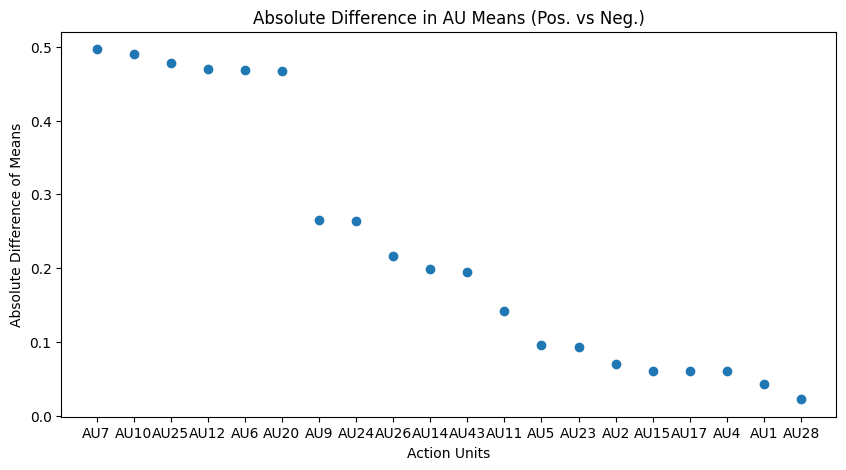

In [36]:
# au_visualization.png
# The x axis must correspond to which AU is being plotted, in the sorted order. Each data point must be correctly labeled with the name of the AU.
# The y axis must correspond to the absolute difference of means for that AU.
# By default, plt.plot() connects all the points as if they belonged to a continuous function. 
# Given the discrete nature of the x axis, we recommend using individual markers to display each data point
import matplotlib.pyplot as plt
import numpy as np

# get the AUs and the differences
aus, diffs = zip(*sorted_diffs)

# plot the AUs and the differences
plt.figure(figsize=(10, 5))
plt.plot(aus, diffs, marker='o', linestyle='None')
plt.xlabel('Action Units')
plt.ylabel('Absolute Difference of Means')
plt.title('Absolute Difference in AU Means (Pos. vs Neg.)')
au_visualization_path = os.path.join('..', 'processed', 'au_visualization.png') 
plt.savefig(au_visualization_path)


In [35]:
print(FEAT_EMOTION_COLUMNS)

['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']
